In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [11]:
class HeatElement2D:
    def __init__(self, node_indices, node_coordinates, k, rho, cp):
        self.node_indices = node_indices
        self.node_coordinates = node_coordinates
        self.k = k  # Thermal conductivity
        self.rho = rho  # Density
        self.cp = cp  # Specific heat capacity
        self.local_stiffness_matrix = self.compute_local_stiffness_matrix()
        self.local_capacitance_matrix = self.compute_local_capacitance_matrix()

    def compute_local_stiffness_matrix(self):
        # Number of nodes in the element
        num_nodes = 4
        K_local = np.zeros((num_nodes, num_nodes))

        # Gaussian quadrature points and weights (2x2 integration)
        gauss_points = [
            (-1/np.sqrt(3), -1/np.sqrt(3)),
            (1/np.sqrt(3), -1/np.sqrt(3)),
            (1/np.sqrt(3), 1/np.sqrt(3)),
            (-1/np.sqrt(3), 1/np.sqrt(3))
        ]
        gauss_weights = [1, 1, 1, 1]

        # Material property matrix (isotropic material)
        D = self.k * np.eye(2)

        for gp, weight in zip(gauss_points, gauss_weights):
            xi, eta = gp

            # Shape functions and their derivatives in natural coordinates
            N = np.array([
                0.25 * (1 - xi) * (1 - eta),
                0.25 * (1 + xi) * (1 - eta),
                0.25 * (1 + xi) * (1 + eta),
                0.25 * (1 - xi) * (1 + eta)
            ])

            dN_dxi = np.array([
                [-0.25 * (1 - eta), 0.25 * (1 - eta), 0.25 * (1 + eta), -0.25 * (1 + eta)],
                [-0.25 * (1 - xi), -0.25 * (1 + xi), 0.25 * (1 + xi), 0.25 * (1 - xi)]
            ])

            # Jacobian matrix
            J = dN_dxi @ self.node_coordinates
            det_J = np.linalg.det(J)

            # Inverse of the Jacobian matrix
            inv_J = np.linalg.inv(J)

            # Gradient of shape functions in global coordinates
            dN_dx = inv_J @ dN_dxi

            # B matrix (gradient matrix)
            B = dN_dx

            # Stiffness matrix contribution
            K_local += (B.T @ D @ B) * det_J * weight

        return K_local

    def compute_local_capacitance_matrix(self):
        # Number of nodes in the element
        num_nodes = 4
        C_local = np.zeros((num_nodes, num_nodes))

        # Gaussian quadrature points and weights (2x2 integration)
        gauss_points = [
            (-1/np.sqrt(3), -1/np.sqrt(3)),
            (1/np.sqrt(3), -1/np.sqrt(3)),
            (1/np.sqrt(3), 1/np.sqrt(3)),
            (-1/np.sqrt(3), 1/np.sqrt(3))
        ]
        gauss_weights = [1, 1, 1, 1]

        for gp, weight in zip(gauss_points, gauss_weights):
            xi, eta = gp

            # Shape functions
            N = np.array([
                0.25 * (1 - xi) * (1 - eta),
                0.25 * (1 + xi) * (1 - eta),
                0.25 * (1 + xi) * (1 + eta),
                0.25 * (1 - xi) * (1 + eta)
            ])

            # Jacobian matrix
            dN_dxi = np.array([
                [-0.25 * (1 - eta), 0.25 * (1 - eta), 0.25 * (1 + eta), -0.25 * (1 + eta)],
                [-0.25 * (1 - xi), -0.25 * (1 + xi), 0.25 * (1 + xi), 0.25 * (1 - xi)]
            ])
            J = dN_dxi @ self.node_coordinates
            det_J = np.linalg.det(J)

            # Capacitance matrix contribution
            C_local += np.outer(N, N) * det_J * weight * self.rho * self.cp

        return C_local


In [12]:
class HeatSystem2D:
    def __init__(self, elements, num_nodes, boundary_conditions, heat_sources):
        self.elements = elements
        self.num_nodes = num_nodes
        self.boundary_conditions = boundary_conditions
        self.heat_sources = heat_sources


In [13]:
class Solver:
    def __init__(self, system):
        self.system = system

    def solve_transient(self, dt, total_time, initial_temperatures):
        # Assemble global matrices
        K_global, C_global, F_global = self.assemble_global_matrices()

        # Apply boundary conditions
        Kuu, Cuu, Fu, known_dofs, unknown_dofs = self.apply_boundary_conditions(K_global, C_global, F_global)

        # Initialize temperature vector
        T = initial_temperatures.copy()

        # Log temperatures over time
        temperature_history = [T.copy()]

        # Time-stepping loop
        time = 0
        while time < total_time:
            # Update time
            time += dt

            # Partition the temperature vector into known and unknown DOFs
            T_unknown = T[unknown_dofs]
            T_known = T[known_dofs]

            # Implicit Euler method: (Cuu + dt * Kuu) T_unknown^{n+1} = Cuu @ T_unknown^n + dt * Fu - dt * Kuu @ T_known
            A = Cuu + dt * Kuu
            b = Cuu @ T_unknown + dt * Fu

            # Solve for T_unknown^{n+1}
            T_unknown = np.linalg.solve(A, b)

            # Merge known and unknown temperatures
            T[unknown_dofs] = T_unknown

            # Log temperatures
            temperature_history.append(T.copy())

        return temperature_history

    def assemble_global_matrices(self):
        # Assemble global stiffness matrix and capacitance matrix
        num_nodes = self.system.num_nodes
        K_global = np.zeros((num_nodes, num_nodes))
        C_global = np.zeros((num_nodes, num_nodes))

        for element in self.system.elements:
            K_local = element.local_stiffness_matrix
            C_local = element.local_capacitance_matrix
            node_indices = element.node_indices

            for i, node_i in enumerate(node_indices):
                for j, node_j in enumerate(node_indices):
                    K_global[node_i, node_j] += K_local[i, j]
                    C_global[node_i, node_j] += C_local[i, j]

        # Assemble global force vector (heat sources)
        F_global = np.zeros(num_nodes)
        for node_index, heat_source in self.system.heat_sources:
            F_global[node_index] += heat_source

        return K_global, C_global, F_global

    def apply_boundary_conditions(self, K_global, C_global, F_global):
        # Identify known and unknown degrees of freedom (DOFs)
        known_dofs = [bc[0] for bc in self.system.boundary_conditions]
        unknown_dofs = [i for i in range(self.system.num_nodes) if i not in known_dofs]

        # Partition the global matrices and force vector
        Kuu = K_global[np.ix_(unknown_dofs, unknown_dofs)]
        Cuu = C_global[np.ix_(unknown_dofs, unknown_dofs)]
        Fu = F_global[unknown_dofs]

        # Modify the force vector to account for known temperatures
        for bc in self.system.boundary_conditions:
            node_index, temperature = bc
            Fu -= K_global[np.ix_(unknown_dofs, [node_index])].flatten() * temperature

        return Kuu, Cuu, Fu, known_dofs, unknown_dofs


In [31]:
class Plotter:
    def __init__(self, nodal_coordinates, temperature_history):
        self.nodal_coordinates = nodal_coordinates
        self.temperature_history = temperature_history
        self.x = nodal_coordinates[:, 0]
        self.y = nodal_coordinates[:, 1]

    def plot_temperature_distribution(self, time_step):
        """Plot the temperature distribution at a specific time step."""
        plt.figure()
        triangulation = plt.tricontourf(self.x, self.y, self.temperature_history[time_step], levels=20, cmap='hot')
        plt.colorbar(triangulation, label='Temperature (°C)')
        plt.title(f'Temperature Distribution at Time Step {time_step}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

    def animate_temperature_distribution(self, dt, save_path=None):
        """
        Animate the temperature distribution over time.
        If `save_path` is provided, the animation will be saved to the specified file.
        """
        fig, ax = plt.subplots()
        cbar = None  # Initialize colorbar
        triangulation = plt.tricontourf(self.x, self.y, self.temperature_history[-1], levels=20, cmap='hot')
        cbar = plt.colorbar(triangulation, label='Temperature (°C)')


        def update(frame):
            nonlocal cbar  # Use the colorbar defined outside the function

            ax.clear()

            # Plot the temperature distribution
            triangulation = ax.tricontourf(self.x, self.y, self.temperature_history[frame], levels=20, cmap='hot')
            ax.set_title(f'Time: {frame * dt:.2f} s')

            # Add colorbar if it doesn't exist
            if cbar is None:
                cbar = fig.colorbar(triangulation, ax=ax, label='Temperature (°C)')

            return triangulation

        ani = animation.FuncAnimation(fig, update, frames=len(self.temperature_history), interval=50)

        # Save the animation if a save path is provided
        if save_path:
            print(f"Saving animation to {save_path}...")
            ani.save(save_path, writer='ffmpeg', fps=10)  # Use 'ffmpeg' for .mp4 or 'imagemagick' for .gif
            print("Animation saved!")

        plt.show()

In [15]:
# Define connectivity and nodal coordinates
num_x = 30
num_y = 30
dx = 1 / num_x
dy = 1 / num_y

# Generate nodal coordinates
nodal_coordinates = np.array([[i * dx, j * dy] for j in range(num_y + 1) for i in range(num_x + 1)])

# Generate connectivity (each element is a quadrilateral)
connectivity = []
for j in range(num_y):
    for i in range(num_x):
        n1 = j * (num_x + 1) + i
        n2 = n1 + 1
        n3 = n1 + (num_x + 1)
        n4 = n3 + 1
        connectivity.append([n1, n2, n4, n3])

connectivity = np.array(connectivity)

# Define boundary conditions
boundary_conditions = []

T_bottom = 0  # Bottom boundary (y = 0) -> T = 0
T_top = 1  # Top boundary (y = num_y) -> T = 1
T_left = 0  # Left boundary (x = 0) -> T = 0
T_right = 0  # Right boundary (x = num_x) -> T = 0

bottom_nodes = range(0, num_x + 1)
boundary_conditions += [[i, T_bottom] for i in bottom_nodes]

top_nodes = range(num_x * (num_y + 1), (num_x + 1) * (num_y + 1))
boundary_conditions += [[i, T_top] for i in top_nodes]

left_nodes = range(0, (num_x + 1) * (num_y + 1), num_x + 1)
boundary_conditions += [[i, T_left] for i in left_nodes]

right_nodes = range(num_x, (num_x + 1) * (num_y + 1), num_x + 1)
boundary_conditions += [[i, T_right] for i in right_nodes]

# Define heat sources (node_index, heat_source)
heat_sources = [
    # [4, 10]  # Heat source at node 4
]

num_nodes = len(nodal_coordinates)
k = 1.0  # Thermal conductivity
rho = 1.0  # Density
cp = 1.0  # Specific heat capacity

# Create elements
elements = []
for node_indices in connectivity:
    node_coords = nodal_coordinates[node_indices]
    element = HeatElement2D(node_indices, node_coords, k, rho, cp)
    elements.append(element)

# Create system
system = HeatSystem2D(elements, num_nodes, boundary_conditions, heat_sources)


In [16]:
# Solve the transient system
dt = 0.01  # Time step size
total_time = 0.5  # Total simulation time
initial_temperatures = np.zeros(num_nodes)  # Initial temperatures

solver = Solver(system)
temperature_history = solver.solve_transient(dt, total_time, initial_temperatures)


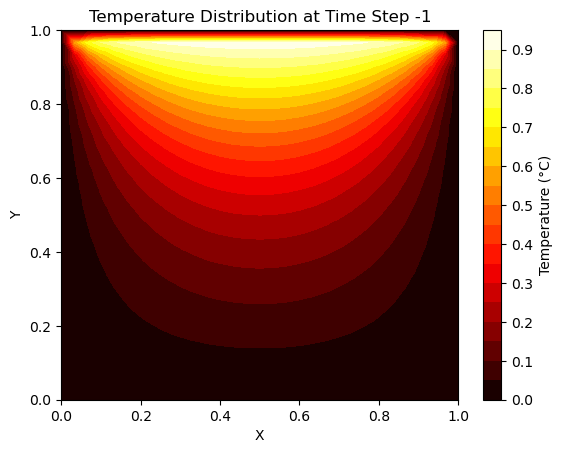

Saving animation to heat_diffusion_animation.mp4...
Animation saved!


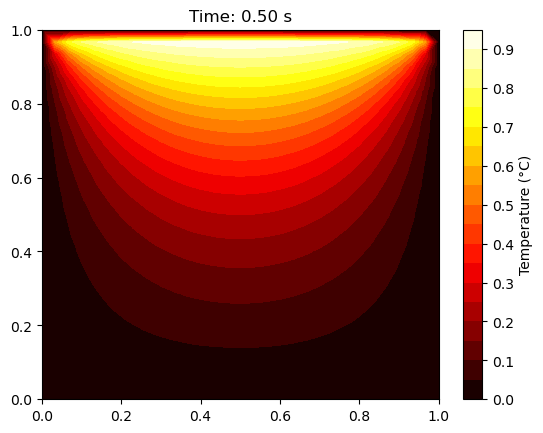

In [32]:
# Plot and animate results
plotter = Plotter(nodal_coordinates, temperature_history)
# plotter.plot_temperature_distribution(time_step=0)  # Plot initial temperature distribution
plotter.plot_temperature_distribution(time_step=-1)  # Plot final temperature distribution
plotter.animate_temperature_distribution(dt, save_path='heat_diffusion_animation.mp4')  # Animate temperature distribution over time